<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
ساعت چنده؟
</font>
</h1>

---

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
وارد کردن کتابخانه‌های مورد نیاز
</font>
</h2>

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
در این بخش کتابخانه‌های مورد نیاز برای انجام پروژه را وارد می‌کنیم.
</font>
</p>

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
بارگذاری تصاویر
</font>
</h2>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
تصاویری که در به عنوان نمونه در اختیار شما قرار گرفته است را در سلول زیر بارگذاری کنید. و سپس به کمک <code>matplotlib</code> نمایش دهید.
</font>
</p>

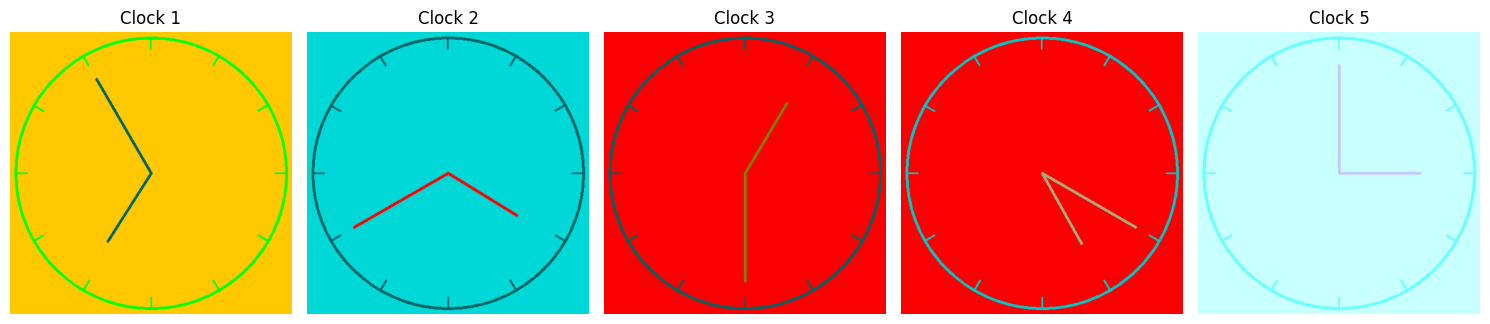

In [31]:
clocks = []
for i in range(1, 6):
    clocks.append(cv2.imread(f"../Data/clock{i}.png"))

plt.figure(figsize=(15, 8))

for i, clock in enumerate(clocks):
    plt.subplot(1, 5, i + 1)
    plt.title(f"Clock {i+1}")
    plt.axis("off")
    plt.imshow(cv2.cvtColor(clock, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
سیاه و سفید سازی تصویر
</font>
</h2>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
با استفاده از تابعی که در تمرین پیش نوشتید،  در مرحله تصاویر را به شکل ساعت های نرمال درآورید.
</font>
</p>

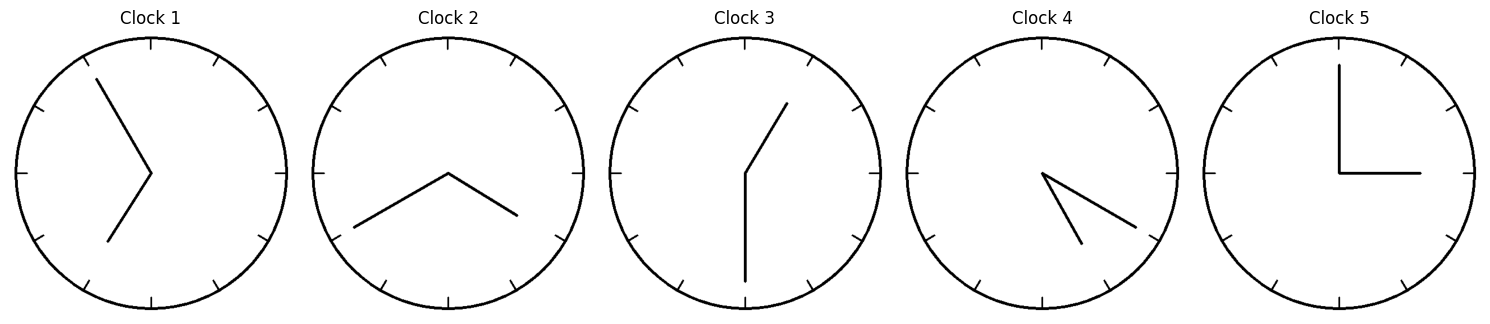

In [32]:
def black_white_convertor(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    background_pixel = np.argmax(hist)
    output = np.zeros_like(img, dtype=np.uint8)
    output[img == background_pixel] = 255
    return output


clocks_bw = []

plt.figure(figsize=(15, 8))

for i, clock in enumerate(clocks):
    clock_bw = black_white_convertor(clock)
    clocks_bw.append(clock_bw)
    plt.subplot(1, 5, i + 1)
    plt.title(f"Clock {i+1}")
    plt.axis("off")
    plt.imshow(clock_bw, cmap="gray")

plt.tight_layout()
plt.show()

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
پیدا کردن ساعت و عقربه ها
</font>
</h2>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
به کمک تابعی که در تمرین قبل نوشتید ساعت و عقربه ها را پیدا کنید. دقت کنید در تمرین قبل خروجی تابع شما یک تصویر حاوی ساعت و عقربه های علامت گذاری شده بود اما تابعی که در سلول زیر مینویسید باید در نهایت تابع، عقربه ساعت شمار، عقربه دقیقه شمار و مرکز ساعت را return کند.
</font>
</p>

In [33]:
import math


def detect_clock(image):
    edges = cv2.Canny(image, 50, 150)

    circles = cv2.HoughCircles(
        edges,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=50,
        param1=30,
        param2=20,
        minRadius=238,
        maxRadius=243,
    )

    if circles is None:
        print("No circle found")
        return None, None, None

    circles = np.uint16(np.around(circles))
    circle = circles[0, 0]
    x, y, r = circle
    center = (x, y)

    lines = cv2.HoughLinesP(
        edges, rho=1, theta=np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10
    )

    if lines is None:
        print("No lines found")
        return None, None, None

    valid_lines = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        length1 = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        mid_x1, mid_y1 = (x1 + x2) / 2, (y1 + y2) / 2
        dist_from_center1 = np.sqrt(
            (mid_x1 - center[0]) ** 2 + (mid_y1 - center[1]) ** 2
        )

        if dist_from_center1 < r / 2 and length1 > 100:
            angle1 = math.degrees(math.atan2(y2 - y1, x2 - x1))
            angle1 = (angle1 + 360) % 360
            is_parallel = False
            for j, line2 in enumerate(valid_lines):
                x3, y3, x4, y4 = line2[0]
                length2 = np.sqrt((x4 - x3) ** 2 + (y4 - y3) ** 2)
                angle2 = math.degrees(math.atan2(y4 - y3, x4 - x3))
                angle2 = (angle2 + 360) % 360

                if abs(angle1 - angle2) < 10 or abs(angle1 - angle2) > 350:
                    is_parallel = True
                    if length1 > length2:
                        valid_lines[j] = line
                    break
            if not is_parallel:
                valid_lines.append(line)

    max_length1, max_length2 = 0, 0
    line_hour, line_minute = None, None

    for line in valid_lines:
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        if length > max_length1:
            max_length2 = max_length1
            line_hour = line_minute
            line_minute = line
            max_length1 = length
        elif length > max_length2:
            max_length2 = length
            line_hour = line

    return line_hour, line_minute, center


clocks_detail = []

for i, clock in enumerate(clocks_bw):
    clock_detail = detect_clock(clock)
    clocks_detail.append(clock_detail)
    print(
        f"Details for clock{i+1}:\nHour hand:{clock_detail[0]}\nMinute hand:{clock_detail[1]}\nCenter:{clock_detail[2]}"
    )

Details for clock1:
Hour hand:[[174 373 252 252]]
Minute hand:[[151  83 250 255]]
Center:(np.uint16(250), np.uint16(250))
Details for clock2:
Hour hand:[[249 253 372 327]]
Minute hand:[[ 85 348 255 250]]
Center:(np.uint16(250), np.uint16(250))
Details for clock3:
Hour hand:[[253 250 326 128]]
Minute hand:[[252 443 252 241]]
Center:(np.uint16(250), np.uint16(250))
Details for clock4:
Hour hand:[[248 252 317 375]]
Minute hand:[[248 251 416 348]]
Center:(np.uint16(250), np.uint16(250))
Details for clock5:
Hour hand:[[249 252 395 252]]
Minute hand:[[247 249 247  59]]
Center:(np.uint16(250), np.uint16(250))


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
خواندن ساعت
</font>
</h2>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
در سلول زیر باید تابعی بنویسید که ورودی مراحل قبل را دریافت کرده و به کمک آن ساعت را تشخیص و اعلام کند.
</font>
</p>

<div dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">

# تئوری تشخیص زمان از روی ساعت آنالوگ

برای تشخیص زمان از یه ساعت آنالوگ با پردازش تصویر، مراحل زیر رو طی می‌کنیم:

1. **پیدا کردن دایره ساعت**

2. **تشخیص عقربه‌ها**

3. **محاسبه زاویه عقربه‌ها**:  
   زاویه هر عقربه رو نسبت به محور افقی (راست = 0 درجه) حساب می‌کنیم.  
   - فرمول: زاویه = degrees(atan2(dy, dx))  
   که dx و dy مختصات بردار از مرکز دایره به وسط خط هستن.

4. **تنظیم زاویه برای ساعت**:  
   تو ساعت، 12 بالا هست (90 درجه تو مختصات تصویر). پس 90 درجه به زاویه اضافه می‌کنیم:  
   - فرمول: زاویه جدید = (زاویه + 90) تقسیم بر 360 و باقی‌مونده  
   حالا:  
   - 0 درجه = ساعت 12  
   - 90 درجه = ساعت 3  
   - 180 درجه = ساعت 6  
   - 270 درجه = ساعت 9

5. **تبدیل زاویه به زمان**:  
   - برای ساعت: هر ساعت 30 درجه است (360 تقسیم بر 12).  
     - فرمول: ساعت = (زاویه ساعت تقسیم بر 30) و باقی‌مونده بر 12  
   - برای دقیقه: هر دقیقه 6 درجه است (360 تقسیم بر 60).  
     - فرمول: دقیقه = (زاویه دقیقه تقسیم بر 6) و باقی‌مونده بر 60  

6. **گرد کردن دقیقه**:  
   دقیقه رو به نزدیک‌ترین مضرب 5 گرد می‌کنیم:  
   - فرمول: دقیقه = (دقیقه تقسیم بر 5 و گرد کردن) ضربدر 5  
   اگه دقیقه به 60 برسه، ساعت رو یکی اضافه می‌کنیم و دقیقه رو صفر می‌کنیم.

**مثال**: اگه زاویه عقربه ساعت 90 درجه (بعد از تنظیم) و زاویه دقیقه 270 درجه باشه:  
- ساعت = (90 تقسیم بر 30) = 3  
- دقیقه = (270 تقسیم بر 6) = 45  
پس زمان: **3:45**

</div>

In [36]:
def calculate_time(line_hour, line_minute, center):
    line_hour_center = (
        (line_hour[0, 0] + line_hour[0, 2]) // 2,
        (line_hour[0, 1] + line_hour[0, 3]) // 2,
    )
    line_minute_center = (
        (line_minute[0, 0] + line_minute[0, 2]) // 2,
        (line_minute[0, 1] + line_minute[0, 3]) // 2,
    )

    line_hour_center_from_clock_center = (
        center[0] - line_hour_center[0],
        center[1] - line_hour_center[1],
    )
    line_minute_center_from_clock_center = (
        center[0] - line_minute_center[0],
        center[1] - line_minute_center[1],
    )

    line_hour_angle = math.degrees(
        math.atan2(
            line_hour_center_from_clock_center[1], line_hour_center_from_clock_center[0]
        )
    )
    line_hour_angle = (line_hour_angle - 90) % 360
    line_minute_angle = math.degrees(
        math.atan2(
            line_minute_center_from_clock_center[1],
            line_minute_center_from_clock_center[0],
        )
    )
    line_minute_angle = (line_minute_angle - 90) % 360

    hour = line_hour_angle / 30 % 12
    minute = line_minute_angle / 6 % 60
    minute = round(minute / 5) * 5
    if minute == 60:
        minute = 0

    return f"{round(hour):02d}:{minute:02d}"


for i, clock in enumerate(clocks_detail):
    print(f"Time for clock{i+1}: {calculate_time(*clock)}")

Time for clock1: 07:55
Time for clock2: 04:40
Time for clock3: 01:30
Time for clock4: 05:20
Time for clock5: 03:00


<div dir="rtl">
<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
<b>سلول جواب‌ساز</b>
</font>
</h2>
</div>
<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
    برای ساخته‌شدن فایل <code>result.zip</code> سلول زیر را اجرا کنید. توجه داشته باشید که پیش از اجرای سلول زیر تغییرات اعمال شده در نت‌بوک را ذخیره کرده باشید (<code>ctrl+s</code>) تا در صورت نیاز به پشتیبانی امکان بررسی کد شما وجود داشته باشد. توجه کنید برای کسب نمره کامل از این تمرین باید هر سه تابع خواسته شده را به درستی بنویسید.
</font>
</p>

In [35]:
import zipfile
from inspect import getsource


def compress(file_names):
    print("File Paths:")
    print(file_names)
    compression = zipfile.ZIP_DEFLATED
    with zipfile.ZipFile("result.zip", mode="w") as zf:
        for file_name in file_names:
            zf.write('./' + file_name, file_name, compress_type=compression)

imp = """
import cv2
import numpy as np
import math
"""

%save black_white_convertor imp + getsource(black_white_convertor)
%save detect_clock imp + getsource(detect_clock)
%save calculate_time imp + getsource(calculate_time)

file_names = ["black_white_convertor.py","detect_clock.py","calculate_time.py", "notebook.ipynb"]
compress(file_names)

The following commands were written to file `black_white_convertor.py`:

import cv2
import numpy as np
import math
def black_white_convertor(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    background_pixel = np.argmax(hist)
    output = np.zeros_like(img, dtype=np.uint8)
    output[img == background_pixel] = 255
    return output

The following commands were written to file `detect_clock.py`:

import cv2
import numpy as np
import math
def detect_clock(image):
    edges = cv2.Canny(image, 50, 150)

    circles = cv2.HoughCircles(
        edges,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=50,
        param1=30,
        param2=20,
        minRadius=238,
        maxRadius=243,
    )

    if circles is None:
        print("No circle found")
        return None, None, None

    circles = np.uint16(np.around(circles))
    circle = circles[0, 0]
    x, y, r = circle
    center = (x, y)

    lines = cv2.Hough